In [1]:
!pip install geopandas
!pip install geopy
!pip install folium
!pip install textdistance

# The Assignment instruction
The assignment is about predicting total sales for every product and store in the next month for a time series dataset consisting of daily sales data.

Submission package should consist of the following:
Script used to conduct the analysis
Excluding cover page, a maximum of 5 slides for purpose of communicating results
There is no set requirement on formatting, however, inclusion of the following sections is recommended.
- Approach including tools used
- Key data cleansing, transformation, variable engineering steps taken
- Model evaluation metric and respective results
- Business implications and recommendations
 
Dataset descriptions:
sales.csv: Daily historical data from January 2013 to October 2015.
items.csv: supplemental information about the items/products.
item_categories.csv: supplemental information about the items categories.
shops.csv: supplemental information about the shops.


# 1) Preparing the coding eviroment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from textdistance import levenshtein

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
%matplotlib inline



Using TensorFlow backend.
/Users/nayefaboutayoun/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nayefaboutayoun/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nayefaboutayoun/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nayefab

 # 2) Loading data 

I loaded all the data required for this project. I created "data" which will contain the result of the next month total sales prediction 

In [3]:
item_categories=pd.read_csv('item_categories.csv')
items=pd.read_csv('items.csv')
sales = pd.read_csv('sales.csv')
shops = pd.read_csv('shops.csv')
data = pd.read_csv('Data.csv') # this is will be file with the sales prediction for next month 

# 3) EDA Analysis and Feature Extraction

### 1) Shops Data
       In this section, I found the following: 
        1- Finding same and duplicated shop names with differe shops_id.
        2- Locating the shops cities on the map
        

In [4]:
shops.head(5)

,system_id,name,id,active_flag
0,R395989,"Voronezh TRC ""Maksimir""",7,X
1,Q222502,Zhukovsky Street,11,X
2,B70025,"RostovNaDonu TRC ""Megacenter Horizon""",39,NaN
3,U750976,"! Yakutsk Ordzhonikidze, 56 Franc",0,NaN
4,F831253,Shop Online Emergencies,12,NaN


In [5]:
shops.name = shops.name.str.replace('[^A-Za-z\s]+','') # remove special charcters in order to improve text extraction
shops

,system_id,name,id,active_flag
0,R395989,Voronezh TRC Maksimir,7,X
1,Q222502,Zhukovsky Street,11,X
2,B70025,RostovNaDonu TRC Megacenter Horizon,39,NaN
3,U750976,Yakutsk Ordzhonikidze Franc,0,NaN
4,F831253,Shop Online Emergencies,12,NaN
...,...,...,...,...
63,Y766029,Moscow shopping center New Age Novokosino,29,NaN
64,O577185,Nizhny Novgorod SEC RIO,34,NaN
65,G989506,Moscow Shop C,22,NaN
66,L428513,Omsk TC Mega,38,NaN


By doing a feature extraction from the "shop" file, I was able to get the "Cities" of the "shops" 

In [6]:
#df.columns = df.columns.str.replace(r"[^a-zA-Z\d\_]+", "") 
shops['city'] = shops['name'].str.split(' ').map(lambda x: x[0]) # Added a City column to the "shop" data 
shops.city=shops.city.str.replace('Digital', "")
shops.city=shops.city.str.replace('St', "")
shops.city=shops.city.str.replace('', "")
shops['city'].unique()

array(['Voronezh', 'Zhukovsky', 'RostovNaDonu', '', 'Shop', 'Kursk',
       'Tyumen', 'Volzhsky', 'Moscow', 'Surgut', 'Kolomna', 'Mytishchi',
       'Itinerant', 'Yaroslavl', 'test', 'Khimki', 'Adygea',
       'Novosibirsk', 'Kazan', 'Ufa', 'Czechs', 'Yakutsk', 'Vologda',
       'Kaluga', 'Samara', 'Balashikha', 'Nizhny', 'Krasnoyarsk', 'Tomsk',
       'Sergiyev', 'Omsk'], dtype=object)

To discover, where are the shops located on the " map"

In [7]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="example app")
shops["loc"] = shops["city"].apply(geolocator.geocode)
shops["point"]= shops["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
shops[['lat', 'lon', 'altitude']] = pd.DataFrame(shops['point'].to_list(), index=shops.index)

In [8]:
shops
shops_4=shops.dropna(subset=['lat','lon'])

shops_4=shops.loc[shops['lon'] > 30]
shops_4

,system_id,name,id,active_flag,city,loc,point,lat,lon,altitude
0,R395989,Voronezh TRC Maksimir,7,X,Voronezh,"(Воронеж, городской округ Воронеж, Воронежская...","(51.6605982, 39.2005858, 0.0)",51.660598,39.200586,0.0
1,Q222502,Zhukovsky Street,11,X,Zhukovsky,"(городской округ Жуковский, Московская область...","(55.569172699999996, 38.116801910954834, 0.0)",55.569173,38.116802,0.0
5,Q647150,Kursk TC Pushkin,19,NaN,Kursk,"(Курск, Курская область, Центральный федеральн...","(51.739433, 36.179604, 0.0)",51.739433,36.179604,0.0
6,B842459,Tyumen SC Green Coast,51,NaN,Tyumen,"(Тюмень, городской округ Тюмень, Тюменская обл...","(57.153534, 65.542274, 0.0)",57.153534,65.542274,0.0
8,P595692,Volzhsky mall Volga Mall,4,NaN,Volzhsky,"(Волжский, городской округ Волжский, Волгоград...","(48.782102, 44.7779843, 0.0)",48.782102,44.777984,0.0
9,P529565,Voronezh Plekhanovskaya,6,NaN,Voronezh,"(Воронеж, городской округ Воронеж, Воронежская...","(51.6605982, 39.2005858, 0.0)",51.660598,39.200586,0.0
10,F94795,Moscow shopping mall area Belyaevo,26,NaN,Moscow,"(Москва, Центральный административный округ, М...","(55.7504461, 37.6174943, 0.0)",55.750446,37.617494,0.0
11,B879440,Moscow shopping center Silver House,32,NaN,Moscow,"(Москва, Центральный административный округ, М...","(55.7504461, 37.6174943, 0.0)",55.750446,37.617494,0.0
12,Q523230,Surgut SEC City Mall,47,NaN,Surgut,"(Сургут, Ханты-Мансийский автономный округ — Ю...","(61.254032, 73.3964, 0.0)",61.254032,73.396400,0.0
13,T366056,Zhukovsky Street Chkalov m,11,NaN,Zhukovsky,"(городской округ Жуковский, Московская область...","(55.569172699999996, 38.116801910954834, 0.0)",55.569173,38.116802,0.0


In [9]:
locations = shops_4[['lat', 'lon']]
locationlist = locations.values.tolist()
len(locationlist)
map = folium.Map(location=[48, 60], zoom_start=3)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=shops['city'][point]).add_to(map)
map

The maps shows that the data contains stores from are different locations in Russia. Many Stores are located in Moscow as shown below 

Text(0.5, 1.0, 'Stores Location accross Russia')

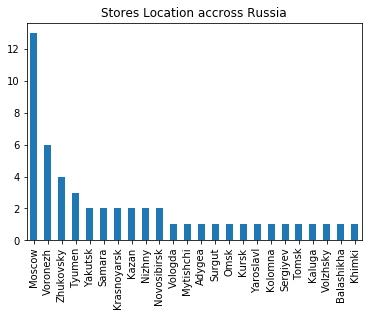

In [10]:
shops_4['city'].value_counts().plot.bar()
plt.title('Stores Location accross Russia')

In [11]:
shops_4['city'].value_counts()

Moscow         13
Voronezh        6
Zhukovsky       4
Tyumen          3
Yakutsk         2
Samara          2
Krasnoyarsk     2
Kazan           2
Nizhny          2
Novosibirsk     2
Vologda         1
Mytishchi       1
Adygea          1
Surgut          1
Omsk            1
Kursk           1
Yaroslavl       1
Kolomna         1
Sergiyev        1
Tomsk           1
Kaluga          1
Volzhsky        1
Balashikha      1
Khimki          1
Name: city, dtype: int64

Discover duplicated shop_id

In [12]:
d=[]
for j in range(1,68):
    df=shops.assign(output=[levenshtein.distance(i, list(shops['name'][j-1])) for i in list(shops['name'])])
    name=list(shops['name'])[j-1]
    df['name_2']=name
    d.append(df)
shops_0=pd.concat(d)
#df1.reset_index(drop=True)
shops_1=shops_0.drop(['active_flag','system_id'],axis=1)
shops_1

,name,id,city,loc,point,lat,lon,altitude,output,name_2
0,Voronezh TRC Maksimir,7,Voronezh,"(Воронеж, городской округ Воронеж, Воронежская...","(51.6605982, 39.2005858, 0.0)",51.660598,39.200586,0.0,0,Voronezh TRC Maksimir
1,Zhukovsky Street,11,Zhukovsky,"(городской округ Жуковский, Московская область...","(55.569172699999996, 38.116801910954834, 0.0)",55.569173,38.116802,0.0,20,Voronezh TRC Maksimir
2,RostovNaDonu TRC Megacenter Horizon,39,RostovNaDonu,None,None,NaN,NaN,NaN,25,Voronezh TRC Maksimir
3,Yakutsk Ordzhonikidze Franc,0,,None,None,NaN,NaN,NaN,26,Voronezh TRC Maksimir
4,Shop Online Emergencies,12,Shop,"(Shop, Cornwall, South West England, England, ...","(50.905888, -4.5216949, 0.0)",50.905888,-4.521695,0.0,20,Voronezh TRC Maksimir
...,...,...,...,...,...,...,...,...,...,...
63,Moscow shopping center New Age Novokosino,29,Moscow,"(Москва, Центральный административный округ, М...","(55.7504461, 37.6174943, 0.0)",55.750446,37.617494,0.0,36,Omsk TC Mega
64,Nizhny Novgorod SEC RIO,34,Nizhny,"(Нижний Новгород, городской округ Нижний Новго...","(56.328571, 44.003506, 0.0)",56.328571,44.003506,0.0,21,Omsk TC Mega
65,Moscow Shop C,22,Moscow,"(Москва, Центральный административный округ, М...","(55.7504461, 37.6174943, 0.0)",55.750446,37.617494,0.0,12,Omsk TC Mega
66,Omsk TC Mega,38,Omsk,"(Омск, городской округ Омск, Омская область, С...","(54.991375, 73.371529, 0.0)",54.991375,73.371529,0.0,0,Omsk TC Mega


In [13]:
shop_table=df.groupby(['city','output','name']).max()
shop_table

altitude  id        lat  \
city      output name                                                        
          17      Yakutsk TC Central Franc              NaN   1        NaN   
          18     St Petersburg TK Sennaya               NaN  43        NaN   
          19     Digital storage Cline                  NaN  55        NaN   
          24      Yakutsk Ordzhonikidze  Franc          NaN   0        NaN   
          25     St Petersburg TK Nevsky Center         NaN  42        NaN   
...                                                     ...  ..        ...   
Yakutsk   19     Yakutsk Ordzhonikidze                  0.0  57  62.027287   
Yaroslavl 27     Yaroslavl shopping center Altair       0.0  59  57.649553   
Zhukovsky 13     Zhukovsky Street                       0.0  11  55.569173   
          21     Zhukovsky Street Chkalov m             0.0  11  55.569173   
test      11     test                                   0.0   0  51.157666   

                                                          lon        name_2  \
city      output name                                                         
          17      Yakutsk TC Central Franc                NaN  Omsk TC Mega   
          18     St Petersburg TK Sennaya                 NaN  Omsk TC Mega   
          19     Digital storage Cline                    NaN  Omsk TC Mega   
          24      Yakutsk Ordzhonikidze  Franc            NaN  Omsk TC Mega   
          25     St Petersburg TK Nevsky Center           NaN  Omsk TC Mega   
...                                                       ...           ...   
Yakutsk   19     Yakutsk Ordzhonikidze             129.732086  Omsk TC Mega   
Yaroslavl 27     Yaroslavl shopping center Altair   39.874858  Omsk TC Mega   
Zhukovsky 13     Zhukovsky Street                   38.116802  Omsk TC Mega   
          21     Zhukovsky Street Chkalov m         38.116802  Omsk TC Mega   
test      11     test                               -1.445857  Omsk TC Mega   

                                                                                           point  \
city      output name                                                                              
          17      Yakutsk TC Central Franc                                                   NaN   
          18     St Petersburg TK Sennaya                                                    NaN   
          19     Digital storage Cline                                                       NaN   
          24      Yakutsk Ordzhonikidze  Franc                                               NaN   
          25     St Petersburg TK Nevsky Center                                              NaN   
...                                                                                          ...   
Yakutsk   19     Yakutsk Ordzhonikidze                              (62.027287, 129.732086, 0.0)   
Yaroslavl 27     Yaroslavl shopping center Altair          (57.64955255, 39.87485827162618, 0.0)   
Zhukovsky 13     Zhukovsky Street                  (55.569172699999996, 38.116801910954834, 0.0)   
          21     Zhukovsky Street Chkalov m        (55.569172699999996, 38.116801910954834, 0.0)   
test      11     test                                              (51.1576661, -1.4458572, 0.0)   

                                                  system_id  
city      output name                                        
          17      Yakutsk TC Central Franc          P433840  
          18     St Petersburg TK Sennaya            B30595  
          19     Digital storage Cline              E294443  
          24      Yakutsk Ordzhonikidze  Franc      U750976  
          25     St Petersburg TK Nevsky Center     M673597  
...                                                     ...  
Yakutsk   19     Yakutsk Ordzhonikidze              P750258  
Yaroslavl 27     Yaroslavl shopping center Altair   G957470  
Zhukovsky 13     Zhukovsky Street                   Q222502  
          21     Zhukovsk

In [14]:
shops_5=shops_1
shops_5=shops_5.drop(['altitude','point','loc'],axis=1)


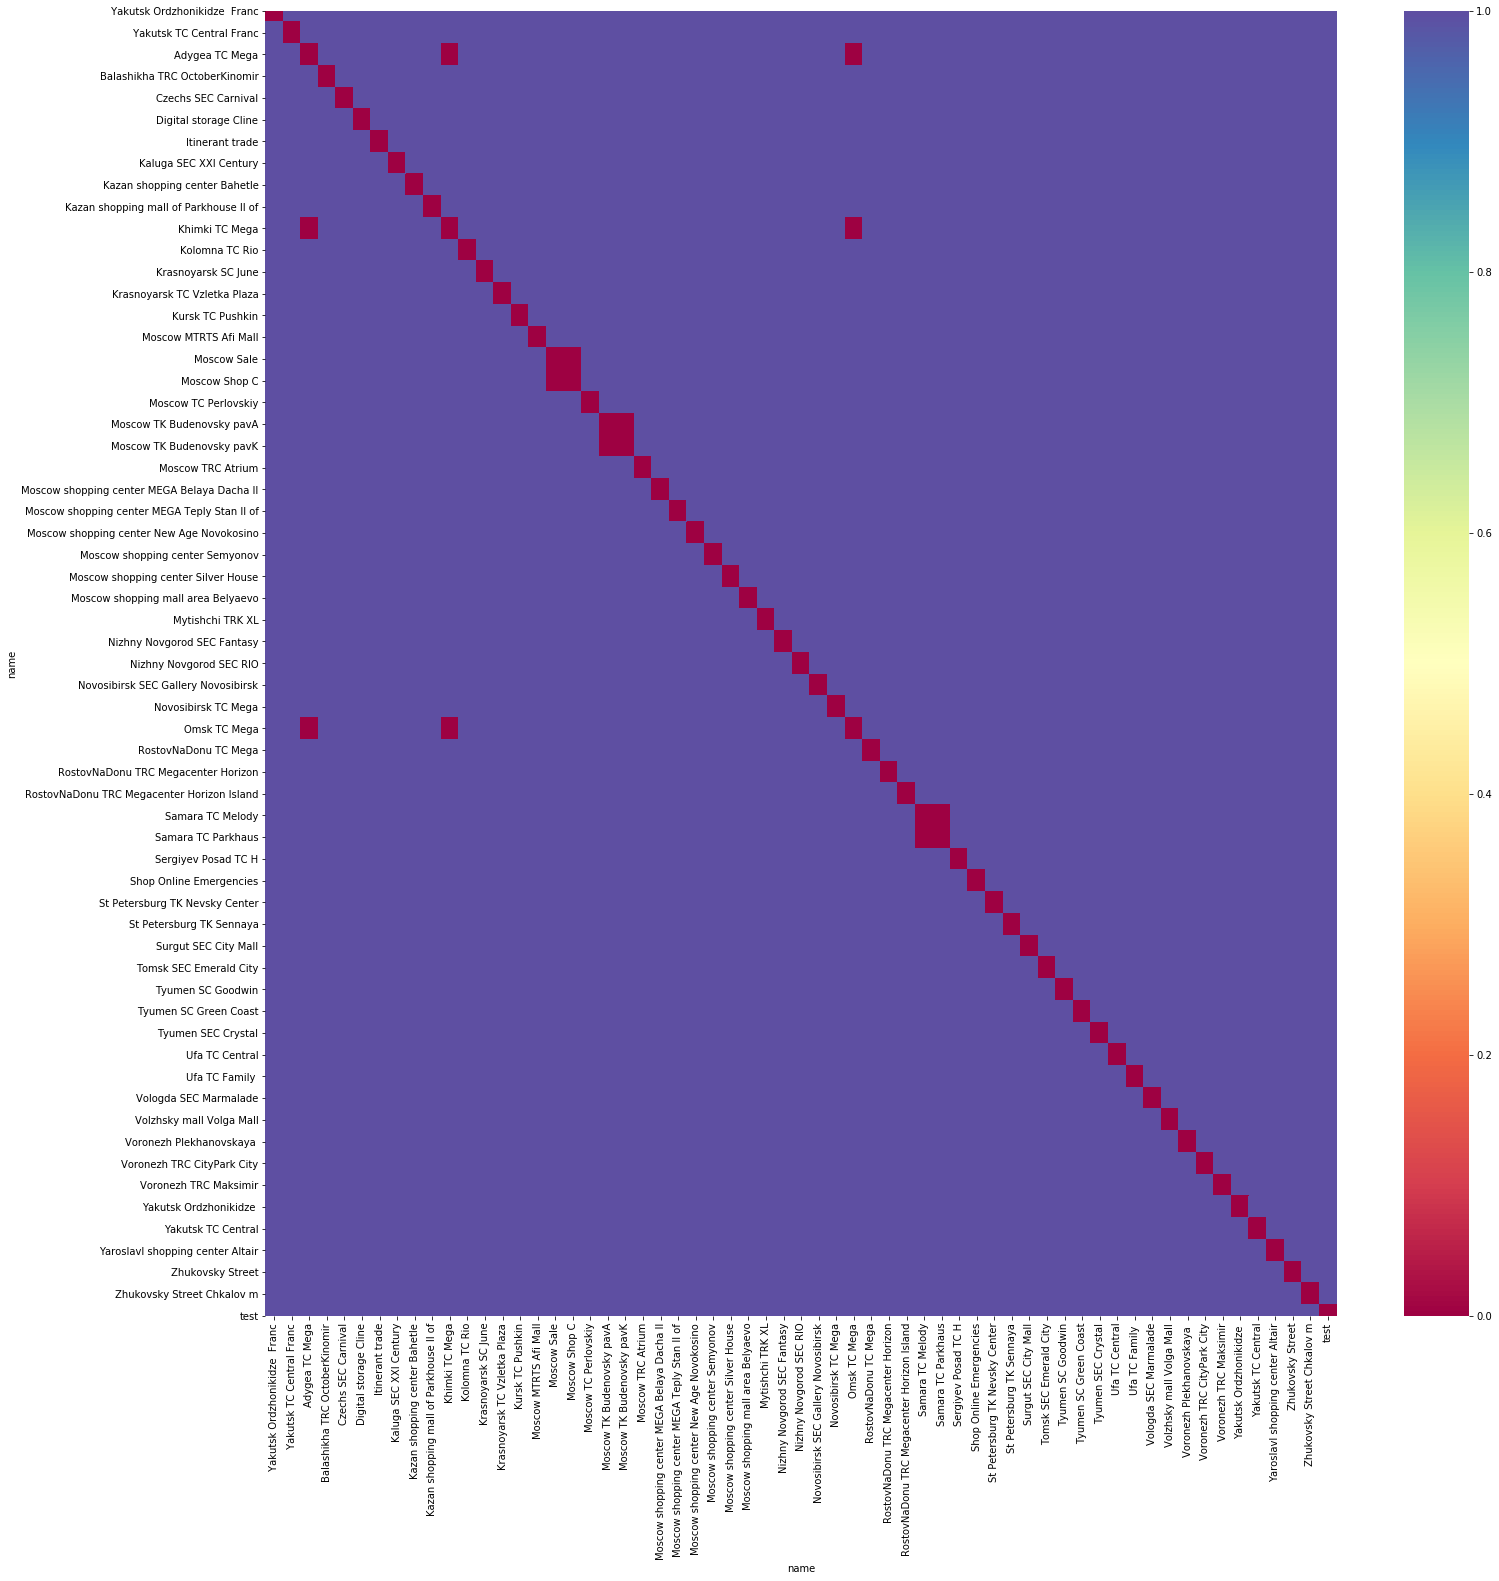

In [15]:

df3=shops_5.pivot_table(index='name_2',columns='name',values='output')
df5=df3.corr()
plt.figure(figsize=(24, 24))
f=sns.heatmap(df5<0.97, cmap="Spectral")

From the above matrix, I detected duplicated entries for same shop_id. So that needs to be dropped in order to have good training test 

This is the final form of the shops data which will be merged later on with sales data 

In [16]:
shops_final=shops_5.drop(['output','name_2'],axis=1)
shops_final['shop_id']=shops_final['id']
shops_final=shops_final.drop(['id'],axis=1)
shops_final

,name,city,lat,lon,shop_id
0,Voronezh TRC Maksimir,Voronezh,51.660598,39.200586,7
1,Zhukovsky Street,Zhukovsky,55.569173,38.116802,11
2,RostovNaDonu TRC Megacenter Horizon,RostovNaDonu,NaN,NaN,39
3,Yakutsk Ordzhonikidze Franc,,NaN,NaN,0
4,Shop Online Emergencies,Shop,50.905888,-4.521695,12
...,...,...,...,...,...
63,Moscow shopping center New Age Novokosino,Moscow,55.750446,37.617494,29
64,Nizhny Novgorod SEC RIO,Nizhny,56.328571,44.003506,34
65,Moscow Shop C,Moscow,55.750446,37.617494,22
66,Omsk TC Mega,Omsk,54.991375,73.371529,38


### 2) Sales data
         In this section, I found the following: 
    1- Finding and removed price outlier ( most probably typo)
    2- Extracting Weekdays to find the impact of weekends on sales

In [17]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [18]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935799e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,3.383346e+03,1.242645e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,2.627246e+04,2.618857e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,4.190000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,1.049000e+03,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,4.200000e+06,2.169000e+03


I have extracted some feature from sales data. I extracted the weekdays from the date. I expect that weekends ( Saturday and Sunday) impact customers behavior by 

In [19]:
# includiing weekend 
sales['date'] = pd.to_datetime(sales['date'])
sales['day_of_week'] = sales['date'].dt.day_name()


In [20]:
sales.drop(['date'], axis=1)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,day_of_week
0,0,59,22154,999.00,1.0,Friday
1,0,25,2552,899.00,1.0,Friday
2,0,25,2552,899.00,-1.0,Wednesday
3,0,25,2554,1709.05,1.0,Saturday
4,0,25,2555,1099.00,1.0,Tuesday
...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,Saturday
2935845,33,25,7460,299.00,1.0,Thursday
2935846,33,25,7459,349.00,1.0,Wednesday
2935847,33,25,7440,299.00,1.0,Thursday


In [21]:
sales['total_sales']=sales['item_price']*sales['item_cnt_day']


In [22]:
train=sales.groupby(['shop_id','item_id','date_block_num','day_of_week','item_price','total_sales']).sum()
#df1=train.groupby(['shop_id','item_id','date_block_num','day_of_week','item_cnt_day']).median()

train

item_cnt_day
shop_id item_id date_block_num day_of_week item_price total_sales              
0       30      1              Friday      265.0      530.0                 4.0
                               Monday      265.0      1060.0                4.0
                               Saturday    265.0      795.0                 3.0
                                                      2385.0                9.0
                               Sunday      265.0      1060.0                4.0
...                                                                         ...
59      22164   30             Tuesday     699.0      699.0                 1.0
        22167   9              Friday      29900.0    29900.0               1.0
                11             Saturday    299.0      299.0                 1.0
                               Tuesday     299.0      299.0                 1.0
                17             Saturday    299.0      299.0                 1.0

[2701298 rows x 1 columns]

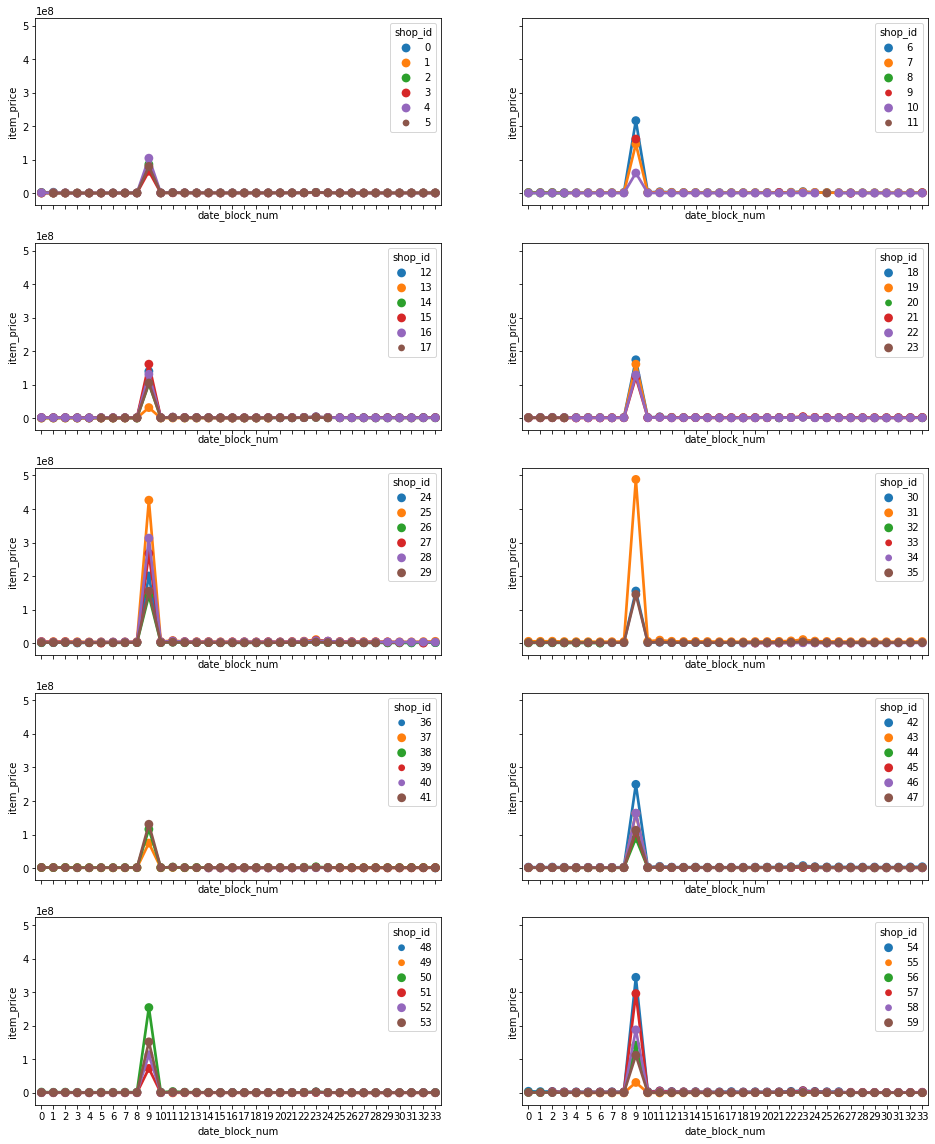

In [23]:
grouping = pd.DataFrame(sales.groupby(['shop_id', 'date_block_num'])['item_price'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_of_graphs = 10
in_graph = ceil(grouping.shop_id.max() / num_of_graphs)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_price', hue='shop_id', data=grouping[np.logical_and(count*in_graph <= grouping['shop_id'], grouping['shop_id'] < (count+1)*in_graph)], ax=axes[i][j])
        count += 1

It can be observed from all above plots that the 'data_block_num=9' has an outlier. That will be removed as shown below.  

This is how it looks after removing the outlier

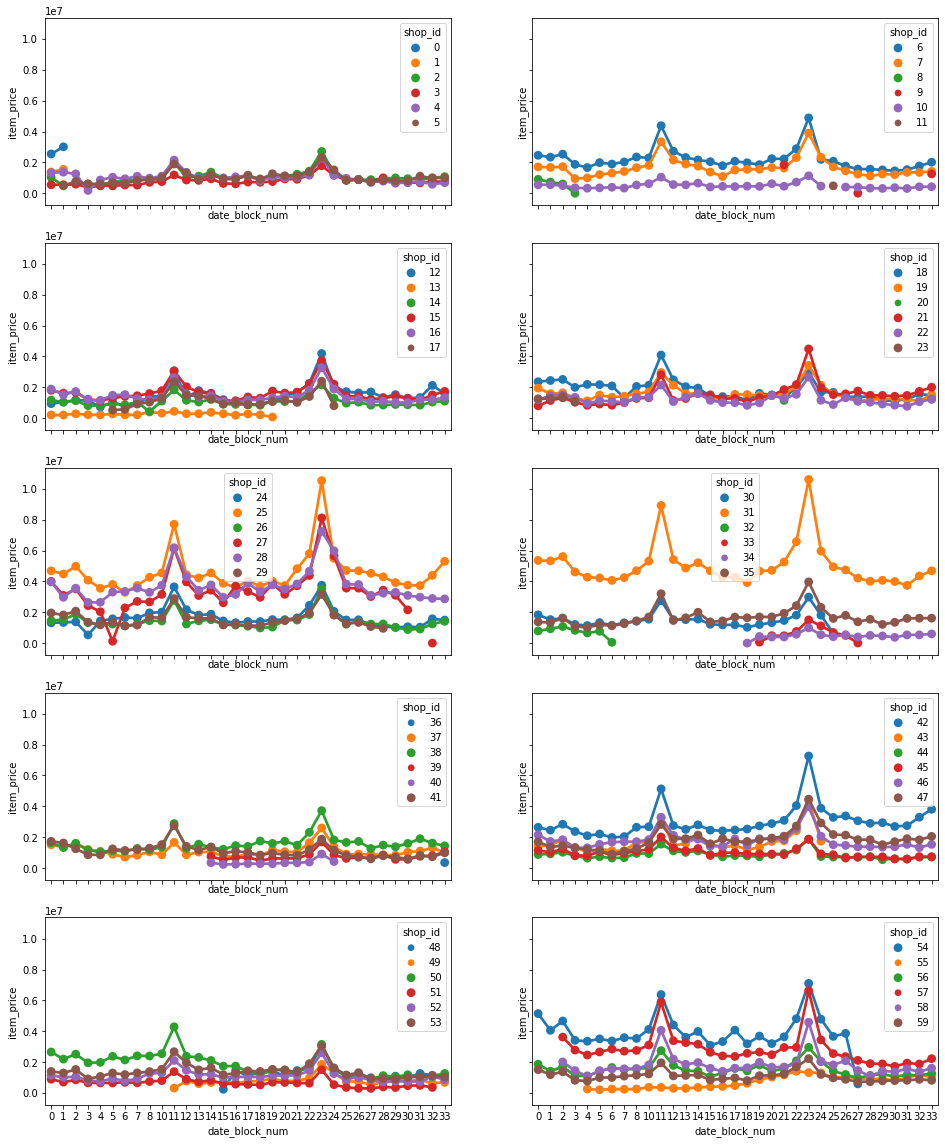

In [24]:
n=sales.loc[sales['date_block_num'] == 9].index 
sales1=sales.drop(n,axis=0) # drop the outlier
grouping = pd.DataFrame(sales1.groupby(['shop_id', 'date_block_num'])['item_price'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
in_graph = ceil(grouping.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_price', hue='shop_id', data=grouping[np.logical_and(count*in_graph <= grouping['shop_id'], grouping['shop_id'] < (count+1)*in_graph)], ax=axes[i][j])
        count += 1

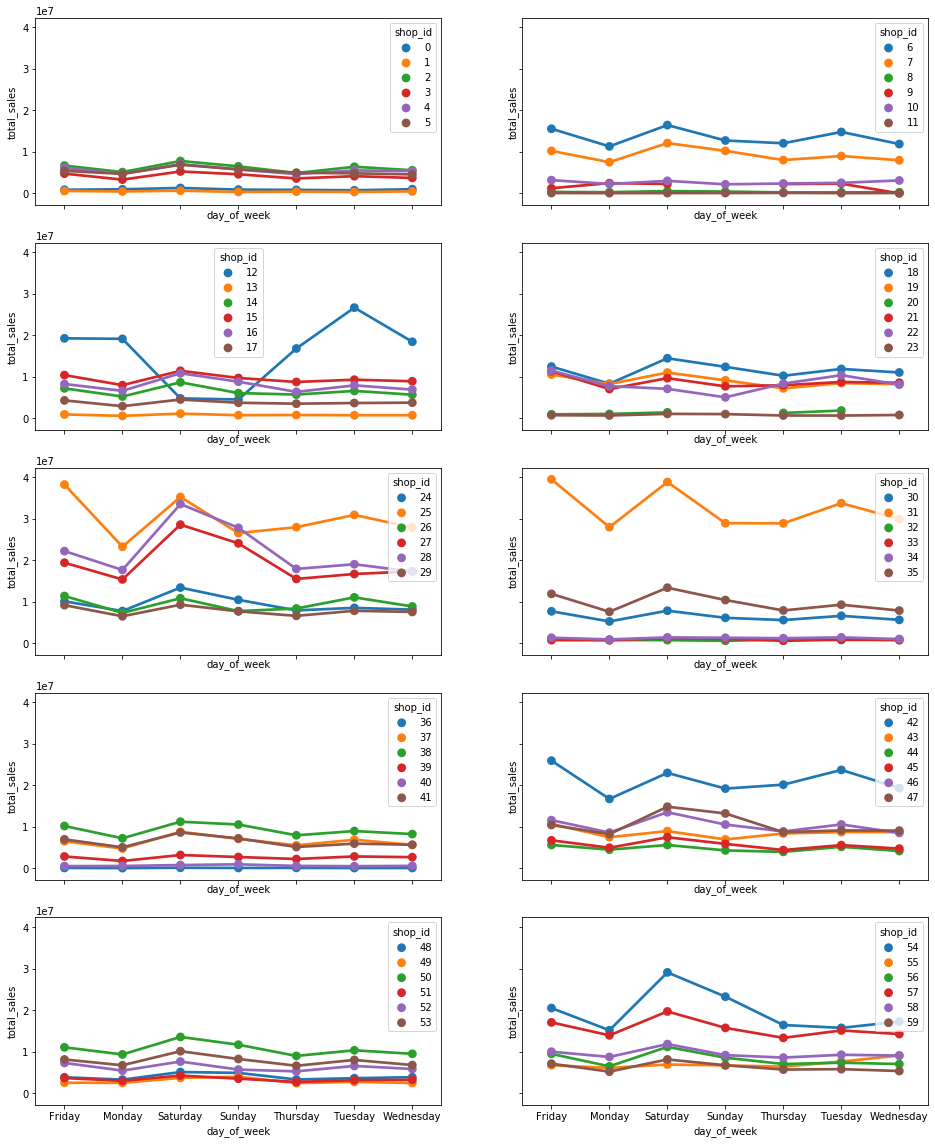

In [25]:
grouping = pd.DataFrame(sales1.groupby(['shop_id', 'day_of_week'])['total_sales'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_of_graphs = 10
in_graph = ceil(grouping.shop_id.max() / num_of_graphs)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='day_of_week', y='total_sales', hue='shop_id', data=grouping[np.logical_and(count*in_graph <= grouping['shop_id'], grouping['shop_id'] < (count+1)*in_graph)], ax=axes[i][j])
        count += 1

In [26]:
sales2=sales1.dropna()
sales2.reset_index()

,index,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day_of_week,total_sales
0,0,2013-02-01,0,59,22154,999.00,1.0,Friday,999.00
1,1,2013-03-01,0,25,2552,899.00,1.0,Friday,899.00
2,2,2013-05-01,0,25,2552,899.00,-1.0,Wednesday,-899.00
3,3,2013-06-01,0,25,2554,1709.05,1.0,Saturday,1709.05
4,4,2013-01-15,0,25,2555,1099.00,1.0,Tuesday,1099.00
...,...,...,...,...,...,...,...,...,...
2841598,2935844,2015-10-10,33,25,7409,299.00,1.0,Saturday,299.00
2841599,2935845,2015-09-10,33,25,7460,299.00,1.0,Thursday,299.00
2841600,2935846,2015-10-14,33,25,7459,349.00,1.0,Wednesday,349.00
2841601,2935847,2015-10-22,33,25,7440,299.00,1.0,Thursday,299.00


## 4) Preprocessing the data 

It is oberved that "item_cnt_day" has a wide range among different items.Some items sell with high quantities. To avoid such bais, the "item_cnt_day" data are normalized. 

x = sales2[['item_cnt_day']].values.astype(float)

min_max_scaler = preprocessing.MinMaxScaler() # Create a minimum and maximum processor object
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled)
sales2['item_cnt_day']=df_normalized
sales2

In [27]:
data_all = sales2.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')

In [28]:
data_all

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  10  ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
...                      ...  .. .. .. .. .. .. .. .. ..  ... .. .. .. .. ..   
59      22154              1   0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22155              0   0  0  0  0  0  1  0  0  0  ...  0  0  0  0  0   
        22162              0   0  0  0  0  0  0  0  0  0  ...  0  9  4  1  1   
        22164              0   0  0  0  0  0  0  0  0  0  ...  0  2  1  2  0   
        22167              0   0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  
...             .. .. .. .. ..  
59      22154    0  0  0  0  0  
        22155    0  0  0  0  0  
        22162    0  0  1  0  0  
        22164    0  1  0  0  0  
        22167    0  0  0  0  0  

[420368 rows x 33 columns]

In [29]:
data_all_1 = pd.merge(data,data_all,on = ['shop_id','item_id'],how = 'left')

data_all_1.fillna(0,inplace = True)

data_all_2=data_all_1.drop(['ID'],axis=1)
data_all_2

/Users/nayefaboutayoun/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,shop_id,item_id,item_price,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,59,22154,999.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25,2552,899.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25,2552,899.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25,2554,1709.05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25,2555,1099.00,1.0,1.0,1.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,37,18474,199.00,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048571,37,18474,199.00,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048572,37,18484,199.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1048573,37,19751,99.00,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Two version of datasets created. Dataset_1 is for Training and Testing the model while Dataset_2 is for prediction

In [30]:
dataset_1,dataset_2 = train_test_split(data_all_2,test_size=0.2) 


In [31]:
x=dataset_1.values[:,:-1]
min_max_scaler = preprocessing.MinMaxScaler() # Create a minimum and maximum processor object
x_scaled = min_max_scaler.fit_transform(x)
X_normalized = pd.DataFrame(x_scaled)

In [32]:
yy=dataset_1.values[:,-1:]
min_max_scaler = preprocessing.MinMaxScaler() # Create a minimum and maximum processor object
y_scaled = min_max_scaler.fit_transform(yy)
y_normalized = pd.DataFrame(y_scaled)

## 3) Training the LSTM Model

In [33]:
X = np.expand_dims(X_normalized,axis = 2)
# the last column is our label
y = y_normalized

In [34]:
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [35]:
X_train=X_train_1[:, 10:34]
X_test=X_test_1[:,10:34]
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape,X.shape)

(713031, 24, 1) (713031, 1) (125829, 24, 1) (125829, 1) (838860, 35, 1)


In [36]:
my_model = Sequential()
my_model.add(LSTM(units=64, input_shape=(24, 1)))
my_model.add(Dropout(0.3))
my_model.add(Dense(1))

my_model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])
my_model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [37]:
s=X_train.shape[0]/100
history=my_model.fit(X_train,y_train,batch_size = int(s),epochs =15)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/15
713031/713031 [==============================] - 44s 61us/step - loss: 7.4668e-05 - mean_squared_error: 7.4668e-05
Epoch 2/15
713031/713031 [==============================] - 47s 66us/step - loss: 5.2965e-05 - mean_squared_error: 5.2965e-05
Epoch 3/15
713031/713031 [==============================] - 60s 85us/step - loss: 4.8083e-05 - mean_squared_error: 4.8083e-05
Epoch 4/15
713031/713031 [==============================] - 53s 75us/step - loss: 4.6938e-05 - mean_squared_error: 4.6938e-05
Epoch 5/15
713031/713031 [==============================] - 61s 85us/step - loss: 4.5227e-05 - mean_squared_error: 4.5227e-05
Epoch 6/15
713031/713031 [==============================] - 50s 70us/step - loss: 4.2512e-05 - mean_squared_error: 4.2512e-05
Epoch 7/15
713031/713031 [==============================] - 60s 84us/step - loss: 3.6703e-05 - mean_squared_error: 3.6703e-05
Epoch 8/15
713031/71303

In [38]:
y_pred = my_model.predict(X_test)
y_pred

array([[-3.8151396e-05],
       [ 3.1120842e-05],
       [-4.9819995e-05],
       ...,
       [ 2.5407656e-04],
       [-5.3777243e-05],
       [-4.4334738e-05]], dtype=float32)

## 4) Model Evaluation
        1- Verify the model convergence 
        2- Find the R2 score

Text(0, 0.5, 'mse')

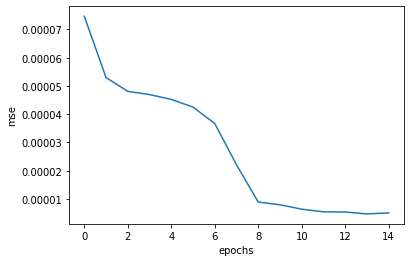

In [39]:
plt.plot(history.history['mean_squared_error']) # to make sure that the model converged 
plt.xlabel('epochs')
plt.ylabel('mse') 

In [40]:
from sklearn.metrics import r2_score
print("R2_score",round(r2_score(y_test, y_pred)*100,1),"%")

R2_score 95.4 %


## 5) Predicted Total sales trend for next month 

In [41]:
dataset_2

,shop_id,item_id,item_price,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
607120,55,2497,249.0,0.0,0.0,0.0,0.0,7.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
948449,5,20949,500.0,0.0,0.0,0.0,0.0,16.0,76.0,60.0,...,123.0,51.0,35.0,132.0,53.0,40.0,47.0,62.0,63.0,43.0
195282,41,2836,1399.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
513354,14,5045,299.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419997,30,5576,2490.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046545,41,4779,299.0,2.0,0.0,2.0,3.0,1.0,3.0,3.0,...,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
930945,56,12463,199.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
271851,51,18539,119.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1030206,28,1495,699.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,2.0,1.0,3.0,1.0,4.0,0.0,0.0,1.0,0.0


In [42]:
gfd = np.expand_dims(dataset_2.values[:,11:-1],axis = 2)
gg=my_model.predict(gfd)

In [43]:
dataset_2['34']=gg  
dataset_2

/Users/nayefaboutayoun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,shop_id,item_id,item_price,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)",34
607120,55,2497,249.0,0.0,0.0,0.0,0.0,7.0,5.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.104222
948449,5,20949,500.0,0.0,0.0,0.0,0.0,16.0,76.0,60.0,...,51.0,35.0,132.0,53.0,40.0,47.0,62.0,63.0,43.0,1.694087
195282,41,2836,1399.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000596
513354,14,5045,299.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014077
419997,30,5576,2490.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046545,41,4779,299.0,2.0,0.0,2.0,3.0,1.0,3.0,3.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212166
930945,56,12463,199.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.031341
271851,51,18539,119.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033715
1030206,28,1495,699.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,3.0,1.0,4.0,0.0,0.0,1.0,0.0,4.559951


In [44]:
d=dataset_2.values[:,2:-1]*dataset_2.values[:,2:3]

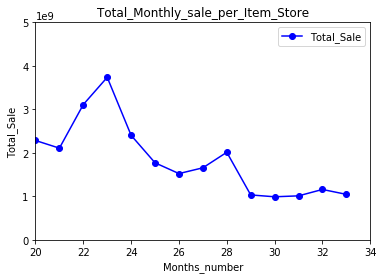

In [45]:

plt.xlim(20,34)
plt.ylim(0,0.5e10)
plt.plot(sum(d), marker='o', linestyle='-', color='blue', 
label='Total_Sale') 
plt.xlabel('Months_number')
plt.ylabel('Total_Sale') 
plt.title('Total_Monthly_sale_per_Item_Store')
plt.legend() 
plt.show()


The top selling items as shown below are Tickets and Gifts Online (shop_id is related to Shop Online) and during Q4 ( October - December)

In [46]:
merged_left = pd.merge(items, item_categories, how='left', left_on='category', right_on='ID')

In [47]:
merged_left_1 = pd.merge(sales2, merged_left, how='left', left_on='item_id', right_on='id')

In [48]:
merged_left_1.sort_values(by='item_cnt_day', ascending=False)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day_of_week,total_sales,item_name,id,category,ID,item_category_name,active_flag
2926264,2015-10-28,33,12,11373,0.908714,2169.0,Wednesday,1.971000e+03,Delivery to the delivery point (Boxberry),11373,9,9,Delivery of goods,NaN
2926263,2015-10-28,33,12,11373,0.908714,2169.0,Wednesday,1.971000e+03,Delivery to the delivery point (Boxberry),11373,9,9,Tickets (digits),X
2316794,2015-01-15,24,12,20949,4.000000,1000.0,Thursday,4.000000e+03,Corporate package white shirt 1C Interest (34 ...,20949,71,71,"Gifts - Bags, Albums, Mats d / mouse",NaN
2878403,2015-09-30,32,12,9248,1692.526158,669.0,Wednesday,1.132300e+06,"Ticket ""IgroMir 2015"" - October 3, 2015 (site)...",9248,80,80,Utilities - Tickets,NaN
2864699,2015-09-30,32,55,9249,1702.825746,637.0,Wednesday,1.084700e+06,"Ticket ""IgroMir 2015"" - October 3, 2015 (websi...",9249,8,8,Tickets (digits),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61422,2013-01-18,0,12,1590,2599.000000,-6.0,Friday,-1.559400e+04,"Assassin's Creed 3. Freedom Edition [PC, Russi...",1590,29,29,Games PC - Collector's Edition,NaN
2025819,2014-10-10,21,12,9242,1433.333333,-9.0,Friday,-1.290000e+04,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",9242,8,8,Tickets (digits),NaN
1804041,2014-10-07,18,14,20949,5.000000,-16.0,Tuesday,-8.000000e+01,Corporate package white shirt 1C Interest (34 ...,20949,71,71,"Gifts - Bags, Albums, Mats d / mouse",NaN
995360,2013-02-11,10,12,8023,15.000000,-22.0,Monday,-3.300000e+02,ZL004 Laser stickers Emoticons are small,8023,66,66,"Gifts - Cards, Stickers",NaN
